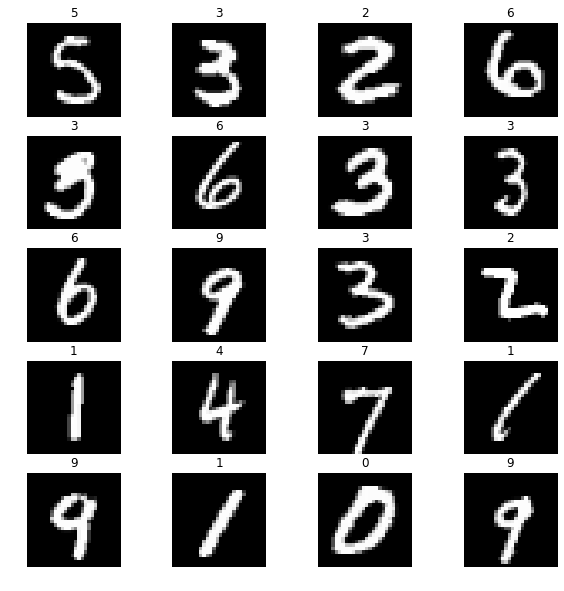

In [2]:
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
%matplotlib inline

with open('mnist_normalized.pkl', 'rb') as f:
    train_set, val_set, __ = pickle.load(f)

rows = 5
cols = 4

fig_1 = plt.figure(1, figsize=(10, 10))
for k in range(1, rows * cols + 1):
    index = random.randint(0, len(train_set))
    img = train_set[index][0]
    label = train_set[index][1]
    sub = fig_1.add_subplot(rows, cols, k)
    sub.axis('off')
    sub.imshow(img.reshape(28, 28), cmap='gray')
    sub.set_title(np.argmax(label))

plt.show()

In [3]:
def mnist_data_generator(dset, batch_size):
    """ generator function that yields batches of (image, label) pairs """
   
    assert 0 < batch_size <= len(dset)

    random.shuffle(dset)
    index = 0

    while True:
        yield dset[index : index + batch_size]
        index += batch_size
        if index + batch_size > len(dset):
            random.shuffle(dset)
            index = 0

In [4]:
""" neural network class. takes as argument a list of integers, refering to the number of neurons in each layer """ 
class Net():

    def __init__(self, layers):
        self.layers = layers
        self.num_layers = len(layers)
        self.weights = [np.random.randn(y, x) for y, x in zip(layers[1:], layers[:-1])] # list of network weight variables
        self.biases = [np.random.randn(y, 1) for y in layers[1:]] # list of network bias variables

    @staticmethod
    def sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    @staticmethod
    def sigmoid_prime(z):
        return Net.sigmoid(z) * (1 - Net.sigmoid(z))

    def test_batch(self, batch):
        """ returns the number of images in batch correctly classified by the network """
        return sum( (1 if np.argmax(self.forward_prop(x)) == np.argmax(y) else 0 for x, y in batch) )
        
    def forward_prop(self, a):
        """ calculates output of network for a given input image"""
        for w, b in zip(self.weights, self.biases):
            a = self.sigmoid(np.dot(w, a) + b)
        return a

    def calc_gradients(self, x, y):
        """ calculates gradients for weights and biases on a single image/label pair """
        
        w_gradients = [np.zeros(w.shape) for w in self.weights] # gradients for all weight variables
        b_gradients = [np.zeros(b.shape) for b in self.biases] # gradients for all bias variables
        activations = [] # list containing output of all layers
        weighted_inputs = [] # list containing z value for all layers (pre activation weighted inputs)

        activation = x  # set initial 'activation' to input
        activations.append(activation)

        # forward_prop
        for w, b in zip(self.weights, self.biases):
            weighted_input = np.dot(w, activation) + b # z = w * x + b, where x in output of previous layer
            weighted_inputs.append(weighted_input)
            activation = self.sigmoid(weighted_input) # a = sigmoid(z)
            activations.append(activation)

        # backward prop
        # start with final layer
        delta = (activations[-1] - y) * self.sigmoid_prime(weighted_inputs[-1]) # BP1
        w_gradients[-1] = np.dot(delta, activations[-2].transpose()) # BP4
        b_gradients[-1] = delta # BP3

        # for each layer (starting 2nd to last & moving back) 
        for l in range(-2, self.num_layers * -1, -1): 
            delta = np.dot(self.weights[l + 1].transpose(), delta) * self.sigmoid_prime(weighted_inputs[l]) # BP2
            w_gradients[l] = np.dot(delta, activations[l-1].transpose()) # BP4
            b_gradients[l] = delta # BP3

        return (w_gradients, b_gradients)

    def train_batch(self, batch, learning_rate):
        """ a single training iteration on a mini batch """
        
        w_gradients = [np.zeros(w.shape) for w in self.weights] # will contain gradients for all weight variables
        b_gradients = [np.zeros(b.shape) for b in self.biases] # will contain gradients for all bias variables
        
        # calculate gradients for entire batch
        for img, label in batch:
            delta_w_gradients, delta_b_gradients = self.calc_gradients(img, label.reshape(-1, 1))
            w_gradients = [nw + dnw for nw, dnw in zip(w_gradients, delta_w_gradients)]
            b_gradients = [nb + dnb for nb, dnb in zip(b_gradients, delta_b_gradients)]
        
        # take average gradient over batch
        w_gradients = [nw / len(batch) for nw in w_gradients]
        b_gradients = [nb / len(batch) for nb in b_gradients]

        # update weights and biases
        self.weights = [w - nw * learning_rate for w, nw in zip(self.weights, w_gradients)]
        self.biases = [b - nb * learning_rate for b, nb in zip(self.biases, b_gradients)]

    def train(self, train_set, val_set, batch_size, learning_rate, n_iterations, n_test):
        """ main method for controlling training process """
        
        # setup generators
        train_gen = mnist_data_generator(dset=train_set, batch_size=batch_size)
        val_gen = mnist_data_generator(dset=val_set, batch_size=n_test)
        
        # train for n_iterations
        for i in range(1, n_iterations + 1, 1):
            
            self.train_batch(batch=next(train_gen), learning_rate=learning_rate)
            
            if i % 1000 == 0: # print out update of training process
                print('Iteration {0}: val_acc = {1}/{2}'.format(i, self.test_batch(next(val_gen)), n_test) )

In [7]:
net_1 = Net(layers=[784, 32, 10]) # instantiate network class
net_1.train(train_set, val_set, batch_size=40, learning_rate=0.1, n_iterations=25000, n_test=1000) # train network

Iteration 1000: val_acc = 224/1000
Iteration 2000: val_acc = 269/1000
Iteration 3000: val_acc = 290/1000
Iteration 4000: val_acc = 324/1000
Iteration 5000: val_acc = 386/1000
Iteration 6000: val_acc = 416/1000
Iteration 7000: val_acc = 447/1000
Iteration 8000: val_acc = 489/1000
Iteration 9000: val_acc = 515/1000
Iteration 10000: val_acc = 573/1000
Iteration 11000: val_acc = 590/1000
Iteration 12000: val_acc = 620/1000
Iteration 13000: val_acc = 635/1000
Iteration 14000: val_acc = 639/1000
Iteration 15000: val_acc = 630/1000
Iteration 16000: val_acc = 635/1000
Iteration 17000: val_acc = 687/1000
Iteration 18000: val_acc = 656/1000
Iteration 19000: val_acc = 658/1000
Iteration 20000: val_acc = 702/1000
Iteration 21000: val_acc = 716/1000
Iteration 22000: val_acc = 730/1000
Iteration 23000: val_acc = 744/1000
Iteration 24000: val_acc = 740/1000
Iteration 25000: val_acc = 719/1000


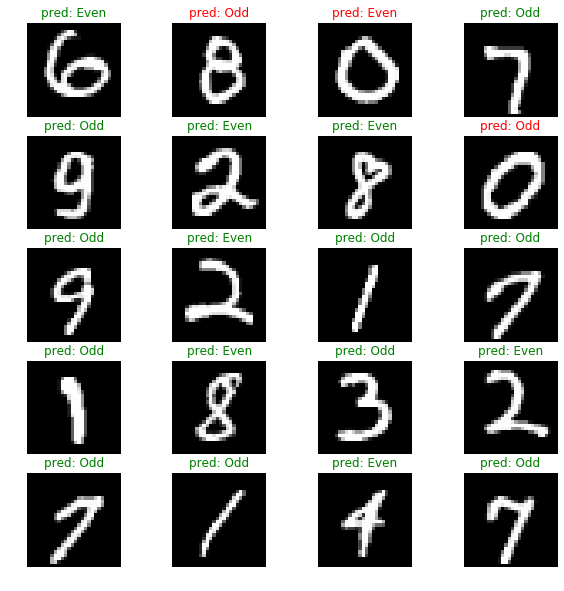

Validation set performance: 7517/10000


In [10]:
# plot 20 random images from validation set alongside our networks prediction

rows = 5
cols = 4

fig_2 = plt.figure(1, figsize=(10, 10))
for k in range(1, rows * cols + 1):
    index = random.randint(0, len(val_set))
    img = val_set[index][0]
    label = np.argmax(val_set[index][1])
    pred = np.argmax(net_1.forward_prop(img))
    sub = fig_2.add_subplot(rows, cols, k)
    sub.axis('off')
    sub.imshow(img.reshape(28, 28), cmap='gray')
    clr = 'green' if label == pred else 'red'
    if pred % 2 == 0:
        sub.set_title('pred: Even' ,color=clr)
    else:
        sub.set_title('pred: Odd', color=clr)

plt.show()

# print networks performance on entire validation set
print('Validation set performance: {0}/{1}'.format(net_1.test_batch(val_set), len(val_set) ) )